# Image subtraction and transient detection (using STDPipe package)

**Lecturer:** Sergey Karpov<br>
**Jupyter Notebook author:** Sergey Karpov

## Objective

Learn how to perform image subtraction and discover astronomical transients in the images

## Key steps

- Pre-process and mask bad regions in the image
- Detect stars in the image and use them for astrometric and photometric calibration
- Get the reference image from public data archives
- Perform image subtraction
- Find the transients in the difference image

As most of lower-level steps are already covered in previous tutorials, we will use higher-level routines from *STDPipe* package for handling them

## Required Python modules

- astropy
- numpy
- matplotlib
- photutils
- astroscrappy
- [STDPipe](https://github.com/karpov-sv/stdpipe/) (and its dependencies)

*STDPipe* may be installed following the instructions at https://stdpipe.readthedocs.io/en/latest/installation.html, or just by doing 
```
pip install stdpipe
``` 

## External dependencies

The tutorial code will require several external packages to be installed:

 - [SExtractor](https://github.com/astromatic/sextractor)
 - [SCAMP](https://github.com/astromatic/scamp)
 - [SWarp](https://github.com/astromatic/swarp)
 - [PSFEx](https://github.com/astromatic/psfex)
 - [HOTPANTS](https://github.com/acbecker/hotpants)

Most of them may be installed directly from package managers, e.g. in Ubuntu or Debian as
```
sudo apt install sextractor scamp psfex swarp
```
or, in Miniconda/Anaconda environment, like that:
```
conda install -c conda-forge astromatic-source-extractor astromatic-scamp astromatic-psfex astromatic-swarp
```

*HOTPANTS* cannot be installed this way, and has to be compiled manually. There is an automated script for doing it available at https://github.com/karpov-sv/stdpipe/blob/master/install_hotpants.sh

In [1]:
# Ensure Astropy version is less than 5.3 - as it breaks the support for compressed FITS files from Pan-STARRS
%pip install astropy==5.2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Generic imports
import matplotlib.pyplot as plt
# Some defaults for Matplotlib
plt.rc('image', origin='lower', cmap='Blues_r')
plt.rc('figure', figsize=[12, 8])

import numpy as np

# AstroPy ecosystem
from astropy.wcs import WCS
from astropy.io import fits as fits

# Photutils
import photutils

# Cosmic ray removal using LACosmic algorithm
import astroscrappy

# Disable some annoying warnings from astropy (optional)
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)
from astropy.utils.exceptions import AstropyUserWarning
warnings.simplefilter(action='ignore', category=AstropyUserWarning)
# Also silence FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

*STDPipe* (Simple Transient Detection Pipeline) is a set of routines intended to help with common tasks during astronomical image analysis. It also conveniently wraps external packages that do not have their own Python interfaces, such as SExtractor, SWarp, SCAMP or HOTPANTS. We will use it to simplify the code, but the same may be of course done directly by calling corresponding executables and loading their results.

We will primarily use the following routines from *STDPipe*:
- `plots.imshow` - drop-in replacement for Matplotlib `imshow` with better intensity scaling
- `photmetry.get_objects_sextractor` - wrapper for running SExtractor and getting its result as an Astropy Table object
- `photometry.measure_objects` - forced aperture photometry with optional sky annulus background subtraction
- `catalogs.get_cat_vizier` - for getting the catalogues from Vizier database
- `pipeline.refine_astrometry` - for refining existing astrometric solution using SCAMP
- `pipeline.calibrate_photometry` - for deriving the photometric solution
- `plots.plot_photometric_match` - for plotting the results of photometric calibration
- `templates.get_survey_image` - for downloading template images from Pan-STARRS, and aligning them with science image
- `subtraction.run_hotpants` - for subtracting the images using HOTPANTS
- `pipeline.filter_transient_candidates` - for filtering the transient candidates based on simple criteria
- `cutouts.get_cutout` - for making the cutouts from the image around transient positions
- `plots.plot_cutout` - for displaying the cutouts

In [3]:
# Ensure STDPipe is installed
%pip install -U stdpipe

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Check external dependencies

!which source-extractor scamp swarp hotpants

/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/source-extractor
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/scamp
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/swarp
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/hotpants


In [5]:
# Load STDPipe sub-modules
from stdpipe import (
    astrometry,
    photometry, 
    catalogs, 
    cutouts,
    templates,
    subtraction, 
    plots, 
    psf, 
    pipeline, 
)

/ltzfs/ASTRO101/anaconda3/envs/astropy52/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and pre-process the science image

The tutorial (and all reasonable data processing in general) expects as an input the *science-ready* image, cleaned as much as possible from instrumental signatures and imaging artefacts. In practice, it means that the image should be
 - bias and dark subtracted
 - flat-fielded.

Also, the artefacts such as saturated stars, bleeding charges, cosmic ray hits etc have to be masked.

Often all this information is distributed directly along with the image, usually as a separate 'mask' file.
But here I will show how to perform basic masking of the image manually.

In [6]:
filename = 'ASTRO101_data/Image_subtraction/ptf_sn_2012p.fits'

In [7]:
# Let's load the image and parse its header!
image = fits.getdata(filename).astype(np.double)
header = fits.getheader(filename)

### Exercise

Inspect the header and see what filter was used for the image. Also, see whether CCD gain is present in some keywords, and what is its value. Remember, the gain is critical for proper image analysis!

In [8]:
# header

In [9]:
# Get some parameters from FITS header
fname = header.get('FILTER', 'unknown')
gain = header.get('GAIN', 1.0)

print('Processing %s: filter %s gain %.2f' 
      % (filename, fname, gain))

Processing ASTRO101_data/Image_subtraction/ptf_sn_2012p.fits: filter ipr gain 1.00


*STDPipe* have some convenience plotting functions collected inside `plots` module. Here we will use one of them, `plots.imshow`, which is a thin wrapper around standard Matplotlib `imshow`, but with quantile-based scaling, optional logarithmic/asinh stretching, buili-in colorbar, etc

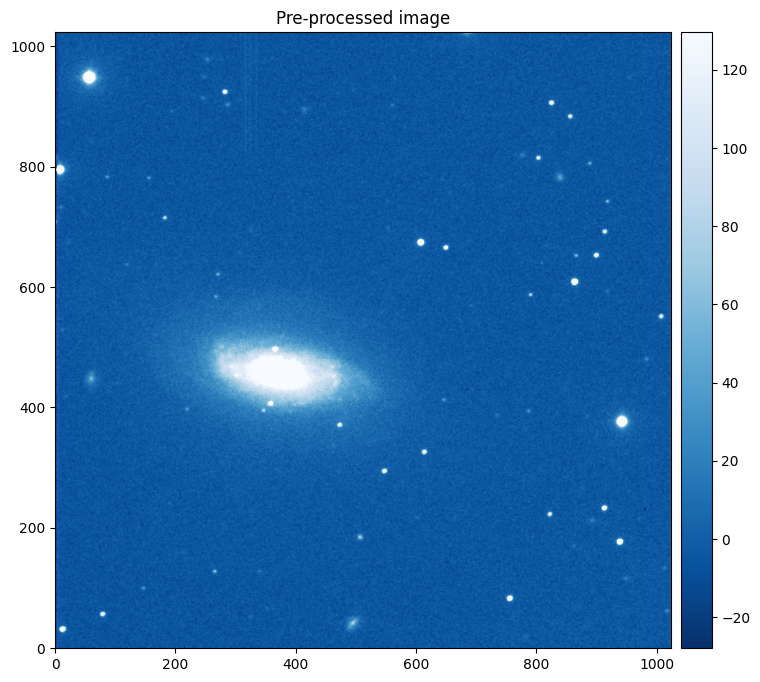

In [10]:
plots.imshow(image)
plt.title('Pre-processed image');

Now we will estimate the saturation level as a 95% quantile above the median level, and mask everything above it. We will also mask cosmic rays in the image.

In [11]:
# Simple estimate of saturation level
saturation = 0.05*np.nanmedian(image) + 0.95*np.nanmax(image) # median + 0.95(max - median)
print('Saturation level is %.1f ADU' % saturation)

mask = image > saturation

# Masking of cosmic rays using Astro-SCRAPPY 

# If the image was background-subtracted or otherwise pre-processed, the code will not 
# be able to correctly guess its error model. So let's compute it manually
bg = photutils.Background2D(image, 128, mask=mask)
var = bg.background_rms**2 + np.abs(image - bg.background)/gain

cmask, cimage = astroscrappy.detect_cosmics(
    image, 
    mask, 
    satlevel=saturation,
    invar=var.astype(np.float32), # Image variance
    verbose=True
)

mask |= cmask

print('%d (%.1f%%) pixels masked in total' % (np.sum(mask), 100.0*np.sum(mask)/image.shape[0]/image.shape[1]))

Saturation level is 29189.1 ADU


/tmp/ipykernel_598069/2251764498.py:11: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  bg = photutils.Background2D(image, 128, mask=mask)


Starting 4 L.A.Cosmic iterations
Iteration 1:
19 cosmic pixels this iteration
Iteration 2:
0 cosmic pixels this iteration
21 (0.0%) pixels masked in total


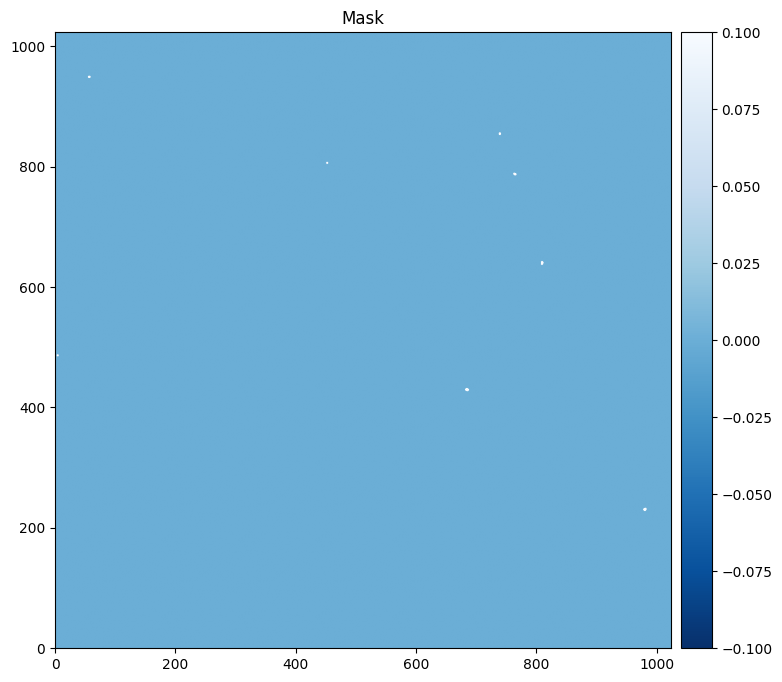

In [12]:
plots.imshow(mask)
plt.title('Mask');

# Detect and measure objects in the image

We will use SExtractor for initial detection of the objects in the image. The wrapper function will automatically prepare necessary config files for it, run the executable, parse its results and cleanup all temporary files created. The wrapper allows passing any configuration option directly to SExtractor through `extra` argument, and get additional measured parameters listed in `extra_param` argument. It returns the results as a standard Astropy Table, ordered by the object brightness. See the full documentation for this wrapper function at https://stdpipe.readthedocs.io/en/latest/detection.html

The detection in SExtractor is based on building the noise model through (grid-based) background and background rms estimation, and then extracting the groups of connected pixels above some pre-defined threshold. It does not use any prior information on the source shape.

In [13]:
obj = photometry.get_objects_sextractor(
    image, 
    # Mask - the objects whose isophotal footprints intersect it will have a flag set
    mask=mask,
    # Initial aperture to be used for getting object flux
    aper=3.0, 
    # Minimal area of the object to be detected, in pixels
    minarea=5,
    # Gain
    gain=gain, 
    # Extra option to automatically reject all objects closer than 10 pixels to image edge.
    edge=10,
    # With this set, we will see how the executable is actually being called
    verbose=True
)

print(len(obj), 'objects detected')

Will run SExtractor like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/sex /tmp/sexkj7dodfk/image.fits -c /tmp/sexkj7dodfk/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.0 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 27817.931640625 -FLAG_IMAGE /tmp/sexkj7dodfk/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /tmp/sexkj7dodfk/cfg.param -CATALOG_NAME /tmp/sexkj7dodfk/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
75 objects detected


Let's check first three objects. The wrapper automatically converts some field names from original SExtractor ones to shorter names (e.g. `MAG_APER`->`mag`, `X_IMAGE`->`x`, `FLAGS`->`flags`, `FWHM`->`fwhm`, etc) 

In [14]:
obj[:3]

<Table length=3>
  mag     magerr      flux       fluxerr         x      ... flags      bg           ra         dec    
  mag      mag         ct           ct          pix     ...            ct          pix         pix    
float32  float32    float32      float32      float32   ... int16   float32      float32     float32  
-------- -------- ------------ ------------ ----------- ... ----- ------------ ----------- -----------
-14.1225   0.0019     445647.6     766.2881     56.5017 ...   260    -3.827841      0.0000      0.0000
-13.4284   0.0025     235151.7     544.3571    941.7778 ...     0    -3.243486      0.0000      0.0000
-11.6450   0.0224     45499.36     939.8616    376.3365 ...     0     45.60411      0.0000      0.0000

We may now overplot these detected objects on top of the image to check the quality of object detection

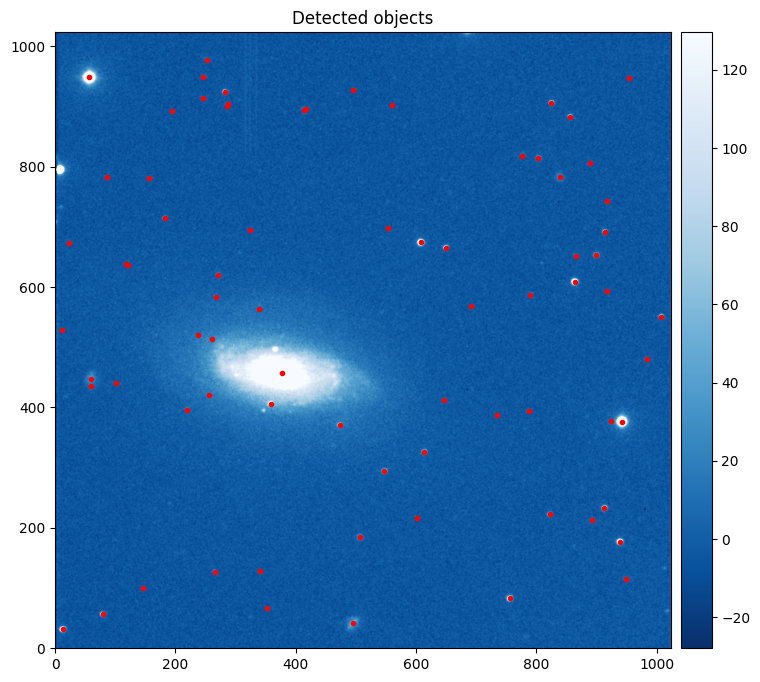

In [15]:
plots.imshow(image, interpolation='bicubic')
plt.plot(obj['x'], obj['y'], 'r.')
plt.title('Detected objects');

# We may optionally zoom into some region to better see the details
# plt.xlim(1000, 1400)
# plt.ylim(1000, 1400)

SExtractor does not allow to do forced photometry (i.e. measurement of an object at user-specified position), nor does it handle local background variations too well. So there is an additional (photutils-based) routine that we will use for forced photometry in a circular aperture with size defined by mean FWHM of the stars in the image. We will also be able to use the same routine with the same parameters for doing the photometry on difference image, in order to get consistent photometric results.

In the measurement routine, the flux is estimated as a sum of counts inside the aperture, minus sum of background values inside the same pixels. Background may be either:
 - global, estimated over a grid with size controlled throgh `bg_size` parameter in a way similar to how *SExtractor* is doing it
 - local, estimated as a sigma-clipped mean value inside the annulus with inner and outer radii set through `bkgann` parameter, and centered on the object. 
 
The error budget of photometric measurements consists of:
 - background noise inside the aperture - this part is empirically estimated and is quite robust
 - Poissonian noise of the source itself. This component is sensitive to knowing exact gain of the detector used

But first, we should get a rough estimation of the seeing. For that, we will first use median FWHM of detected objects, taking into account only unflagged (e.g. not saturated) ones. This method is not *exactly* accurate, as you will see below.

In [16]:
fwhm = np.median(obj['fwhm'][obj['flags'] == 0])
print('Median FWHM is %.1f pixels' % fwhm)

Median FWHM is 5.0 pixels


### Exercise

Check the accuracy of a rough FWHM estimation we made from simple median, and correct it if necessary. Refer to the following figure for general principle (the figure is from [PSFEx documentation](https://psfex.readthedocs.io/en/latest/index.html)).

PSFEx documentation suggests using the mode of the distribution for the objects above S/N > 20 and below the saturation limit. Mode may be (sometimes) approximated as a `3.0*median - 2.0*mean` for the sigma-clipped subset of a distribution. If you are brave enough, try to modify the code below to use this approach. Or just guess the correct value manually.

![](https://psfex.readthedocs.io/en/latest/_images/rhmag.png)

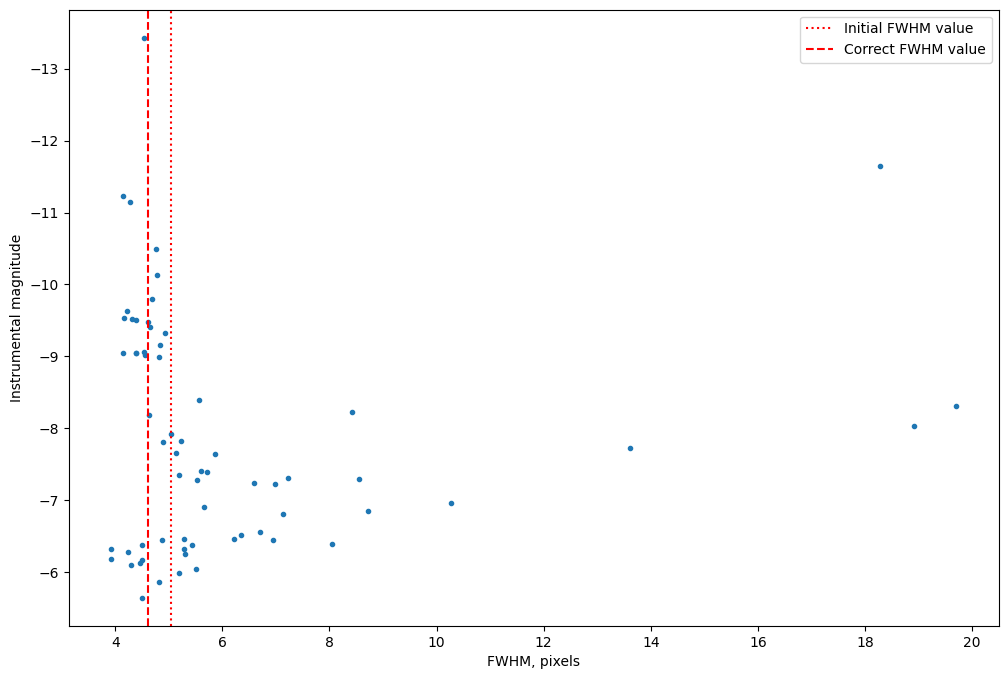

In [17]:
# Exclude saturated objects etc
idx = obj['flags'] == 0

# Also exclude lower-quality objects
idx1 = idx & (obj['magerr'] < 1/20) 
fwhm = np.median(obj['fwhm'][idx1]) # It should be the mode instead of median!

'''from scipy import stats
fwhm = stats.mode(obj['fwhm'][idx1])'''

plt.plot(obj['fwhm'][idx], obj['mag'][idx], '.')
plt.axvline(np.median(obj['fwhm'][idx]), ls=':', color='red', label='Initial FWHM value')
plt.axvline(fwhm, ls='--', color='red', label='Correct FWHM value')
plt.gca().invert_yaxis()
plt.xlabel('FWHM, pixels')
plt.ylabel('Instrumental magnitude')
plt.legend()

We will pass this FWHM to measurement function so that aperture and background radii will be relative to it (if it is not passed, the radii are expected to be in pixels).

The radius of photometric aperture should be selected so that it
 - maximizes the fraction of object flux that falls inside it
 - minimizes the background noise contribution
 - minimizes the chance to also capture the flux from nearby objects
 
Typically, aperture radius of 1.5 to 2 FWHM is considered optimal. However, we will take just 1.0 FWHM for it.

We will also reject all objects with measured S/N < 5, as they are mostly useless for any calibration (and also cannot even be considered reliably detected).

In [18]:
obj = photometry.measure_objects(
    obj, 
    image, 
    mask=mask, 
    fwhm=fwhm, # It will be used for scaling the aperture radius
    gain=gain, # It will be used for computing Poissonian noise contribution
    aper=1.0, # In FWHM units
    bkgann=[5, 7], # In FWHM units
    sn=5, # Minimal S/N to be accepted
    verbose=True
)

print(len(obj), 'objects properly measured')

Estimating global background with 64x64 mesh
Subtracting global background: median -4.3 rms 5.65
Using global background noise map: median 9.4 rms 1.92 + gain 1.0
Scaling aperture radii with FWHM 4.6 pix
Using aperture radius 4.6 pixels
Using local background annulus between 23.1 and 32.3 pixels
Filtering out measurements with S/N < 5.0
65 objects properly measured


# Astrometric calibration

For simplicity, here we will assume that the image is already (roughly) astrometrically calibrated, i.e. that its FITS header contains some WCS solution allowing to map pixel coordinates to sky positions. Such astrometric calibration may be done e.g. using [Astrometry.Net](https://nova.astrometry.net) website. *STDPipe* also contains wrapper functions to perform such blind matching (`astrometry.blind_match_objects` and `astrometry.blind_match_astrometrynet`, see https://stdpipe.readthedocs.io/en/latest/astrometry.html), but we will not use them here.

Instead, we will just load the solution from FITS header.

In [19]:
# Load initial WCS
wcs = WCS(header)

# Get the center position, size and pixel scale for the image
center_ra,center_dec,center_sr = astrometry.get_frame_center(
    wcs=wcs, 
    width=image.shape[1], 
    height=image.shape[0]
)

pixscale = astrometry.get_pixscale(wcs=wcs)

print('Frame center is %.2f %.2f radius %.2f deg, %.2f arcsec/pixel' 
      % (center_ra, center_dec, center_sr, pixscale*3600))

Frame center is 225.01 1.91 radius 0.08 deg, 0.38 arcsec/pixel


# Reference catalogue

Now we may download the catalogue for this sky region from Vizier using a function `catalogs.get_cat_vizier` from *STDPipe*. The routine uses [astroquery](https://astroquery.readthedocs.io/en/latest/) package to send actual queries to data archives.

Catalogue name may be any Vizier identifier, or one of supported shortcuts for popular choices (**ps1, gaiadr2, gaiaedr3, gaiadr3syn, usnob1, gsc, skymapper, apass, sdss, atlas, vsx** etc). The full list of supported catalogue aliases is in `catalogs.catalogs` dictionary.

Column filters may be also provided to limit the output e.g. to brightest objects only. The format is the same as used on Vizier web site.

Some of catalogue shortcuts (e.g. **ps1** and **gaiadr2**) also initiate augmenting the returned catalogue with photometric data not originally stored there, most notably - Johnson-Cousins **B, V, R and I** magnitudes. The transformations used for that are either taken from literature, or derived by cross-matching these catalogues with a large set of Landolt standard stars.

The depth of the catalogue we will request should roughly correspond to the magnitude of the faint stars in our image - if it is much deeper, we will get more spurious matches, and it may worsen the astrometric solution

In [20]:
#Let's get PanSTARRS objects brighter than r=22 mag
cat = catalogs.get_cat_vizier(
    # Center position
    center_ra, 
    center_dec, 
    # Radius in degree
    center_sr, 
    # Catalogue name or alias
    'ps1', 
    # Column filters 
    filters={'rmag':'<22'}
)

print(len(cat), 'catalogue stars')

259 catalogue stars


In [21]:
cat[:3]

<Table length=3>
   RAJ2000       DEJ2000          objID        ...       r_SDSS             i_SDSS        z_SDSS
     deg           deg                         ...                                         mag  
   float64       float64          int64        ...      float64            float64       float64
------------- ------------- ------------------ ... ------------------ ------------------ -------
225.028152540   1.837428750 110202250280825348 ... 21.611310574999997 21.357937250000003 21.3107
225.015089850   1.840212430 110202250150358690 ...     15.54659245308      15.3110193044 15.1946
225.018807510   1.836881970 110202250187734770 ...     20.88784557632      21.0897781376 21.1469

### Exercise

Overplot the catalogue over the image and check whether the stars match with catalogue entries, and whether the depth is comparable. If not, you may adjust the limit we set in the cell above.

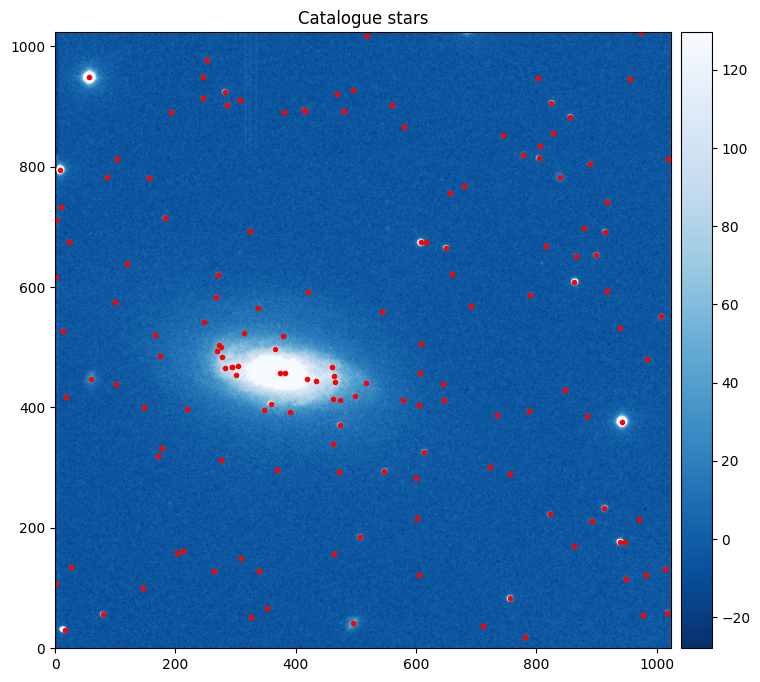

In [22]:
plots.imshow(image, interpolation='bicubic')
plt.title('Catalogue stars')

plt.autoscale(False)

x,y = wcs.all_world2pix(cat['RAJ2000'], cat['DEJ2000'], 0)
plt.plot(x, y, 'r.')

# We may optionally zoom into some region to better see the details
# plt.xlim(0, 100)
# plt.ylim(900, 1000)

# Astrometric refinement

Image subtraction is extremely sensitive to the alignment of images, and it needs the astrometric solution as accurate as possible. Therefore, we will try to refine the astrometric solution based on the positions of detected objects and catalogue stars using *SCAMP* code - again, through *STDPipe* wrapper for it (that also forces it to use our already downloaded catalogue).

In [23]:
# Use SCAMP for astrometric refinement.
wcs = pipeline.refine_astrometry(
    # List of detected objects
    obj, 
    # List of catalogue stars
    cat, 
    # Matching radius
    10*pixscale,
    # Initial astrometric solution
    wcs=wcs, 
    # Polynomial order for distortions
    order=5,
    # Method to use - we need to select SCAMP here
    method='scamp', 
    # Catalogue column name with the closest magnitude
    cat_col_mag='imag', 
    verbose=True
)

if wcs is not None:
    # Remove astrometric keywords from existing header
    astrometry.clear_wcs(
        header, 
        remove_comments=True, 
        remove_underscored=True, 
        remove_history=True
    )
    
    # Update WCS info in the header
    header.update(wcs.to_header(relax=True))
else:
    print("Astrometric refinement failed")

Astrometric refinement using 3.8 arcsec radius, photometric matching and scamp WCS fitting
Using 65 objects and 259 catalogue stars
Using user-provided local catalogue
Will run SCAMP like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/scamp /tmp/scamp704h232_/objects.cat -c /tmp/scamp704h232_/empty.conf -VERBOSE_TYPE QUIET -SOLVE_PHOTOM N -CHECKPLOT_TYPE NONE -WRITE_XML Y -XML_NAME /tmp/scamp704h232_/scamp.xml -PROJECTION_TYPE TPV -CROSSID_RADIUS 3.778600734596857 -DISTORT_DEGREES 5 -HEADER_NAME /tmp/scamp704h232_/objects.head -ASTREF_CATALOG FILE -ASTREFCAT_NAME /tmp/scamp704h232_/catalogue.cat


/ltzfs/ASTRO101/anaconda3/envs/astropy52/lib/python3.11/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


SCAMP run successfully
38 matches, chi2 2.8
Astrometric accuracy: 0.02" 0.01"


# Photometric calibration

Photometric calibration is performed by positionally matching detected objects with catalogue stars, and then building the photometric model for their instrumental magnitudes.

The model includes:
 - catalogue magnitude
 - (optionally spatially varying) zero point
 - (optionally) catalogue color
 - plus, of course, measurement errors
 
and looks like that:
$$ 
\mbox{Catalogue} = \mbox{Instrumental} + C\cdot\mbox{color} + \mbox{polynomial}(x, y, degree) + \mbox{err}
$$

where $\mbox{Catalogue}$ is e.g. $\mbox{V}$ magnitude and $\mbox{color}$ is e.g $\mbox{B-V}$

This is equivalent to the instrumenmtal photometric system defined as $\mbox{V} - C\cdot(\mbox{B-V})$. Thus, the color term captures the difference between the catalogue and instrumental photometric systems, e.g. due to different filters used, etc.

While the calibration may be done manually in simple cases (e.g. by just taking median difference between instrumental and catalogue magnitudes as a zero point), it would be easier to just use *STDPipe* high-level routine `pipeline.calibrate_photometry` for handling it. The routines perform an iterative fitting with rejection of pairs deviating too much (more than `threshold` sigmas) from the model. Optional intrinsic scatter (specified through `max_intrinsic_rms` parameter) may also help accounting for the effects of e.g. multiplicative noise (flatfielding, subpixel sensitivity variations, etc). Its full documentation is at https://stdpipe.readthedocs.io/en/latest/photometry.html

The routine returns the structure with various fields representing e.g. the indices of the objects actually used for the calibration, measured and fitted zero points for individual objects, etc. They all may be used to make various diagnostic plots showing the quality of the fit, and we will see it in more details later.
But the main output is in the field `zero_fn` - it contains the callable that returns the fitted zero point at an arbitrary position within the image. It may be used to convert e.g. measured transient flux (instrumental magnitdue) to calibrated magnitude.


For photometric calibration, we have to select the correct 'primary' catalogue magnitude, with the filter equal (or closest) to the one used for our actual image. The color term, on the other hand, may be in most cases left to (for Pan-STARRS reference catalogue) `gmag-rmag`. 

In [24]:
# Photometric calibration using 2 arcsec matching radius, 
# r magnitude, g-r color and second order spatial variations
m = pipeline.calibrate_photometry(
    obj, 
    cat, 
    # Matching radius, in degrees
    sr=2/3600, 
    # Primary filter column name
    cat_col_mag='imag',
    # Color term
    cat_col_mag1='gmag', 
    cat_col_mag2='rmag', 
    # If set to True, it will include color term in the model
    use_color=False,
    # Allow some scatter on top of formal error bars
    max_intrinsic_rms=0.02, 
    # Spatial order of the model - select 0 if we have few stars, otherwise 2 is enough
    order=0,
    verbose=True
)

# The code above automatically augments the object list 
# with calibrated magnitudes, but we may also do it manually
obj['mag_calib'] = obj['mag'] + m['zero_fn'](
    obj['x'], 
    obj['y']
)
# Zeropoint model errorr is typically small, but we may still add it
obj['mag_calib_err'] = np.hypot(
    obj['magerr'], m['zero_fn'](
        obj['x'], 
        obj['y'], 
        get_err=True
    )
)

Performing photometric calibration of 65 objects vs 259 catalogue stars
Using 2.0 arcsec matching radius, imag magnitude and spatial order 0
Using (gmag - rmag) color for color term
64 initial matches between 65 objects and 259 catalogue stars, sr = 2.00 arcsec
Median separation is 0.10 arcsec
Fitting the model with spatial_order = 0
Using robust fitting
52 objects pass initial quality cuts
Iteration 0 : 52 / 64 - rms 0.46 0.46 - normed 66.76 16.90 - scale 1.46 1.00 - rms 0.02
Iteration 1 : 46 / 64 - rms 0.46 0.17 - normed 2.46 1.56 - scale 0.99 1.00 - rms 0.02
Fitting converged
46 good matches
Intrinsic scatter is 0.02
Photometric calibration finished successfully.


## Plotting calibration results

There is a handy plotting function useful for quick checking of fitting quality and uncorrected trends. It marks the stars used for final model fit with red dots, and flagged (e.g. saturated) stars rejected from the fitting from the start - with yellow diagonal crosses. The rest of points are the ones that got rejected during the iterative model fitting process.

Upper panel shows the model fitting residuals as a function of magnitude. It should be centered on zero, within error bars. 

Lower panel is the same but w.r.t. the color. If the fiilter is selected properly, or if color term is included in the fitting, it also will be around zero. If color term is included, the legend will show the actual photmetric system of the image. Color term should be small - if it is larger than 0.5, it usually mean that the primary filter is selected incorrectly.

(0.0, 1.5)

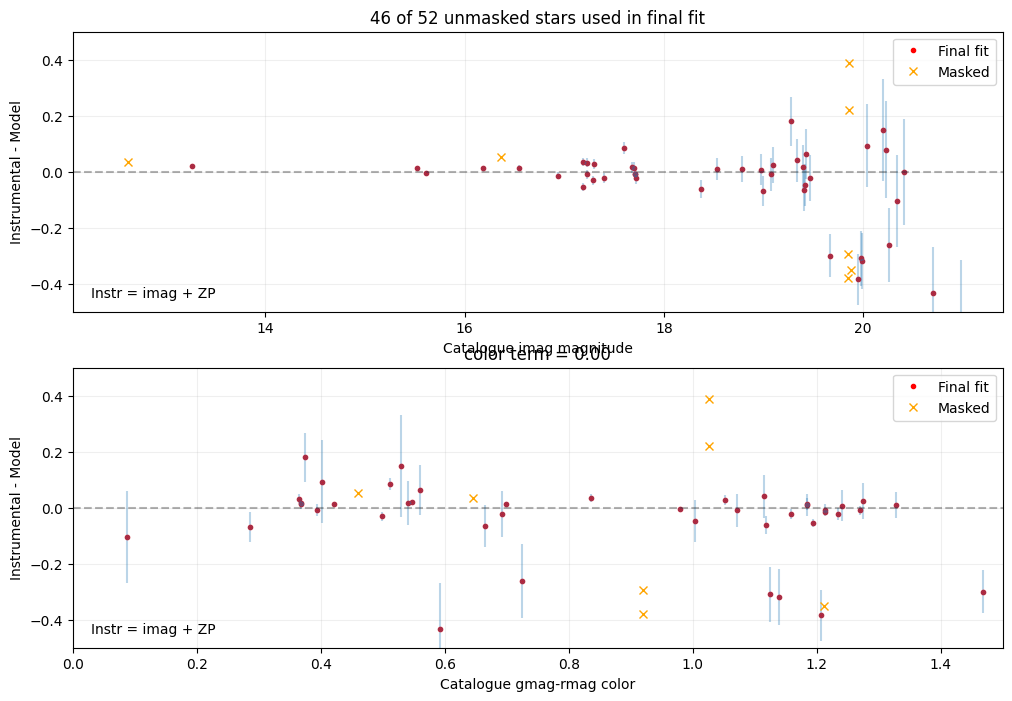

In [25]:
# Photometric residuals as a function of catalogue magnitude
plt.subplot(211)
plots.plot_photometric_match(m)
plt.ylim(-0.5, 0.5)

# Photometric residuals as a function of catalogue color
plt.subplot(212)
plots.plot_photometric_match(m, mode='color')
plt.ylim(-0.5, 0.5)
plt.xlim(0.0, 1.5)

### Exercise

Does the calibration look good? Is there any uncorrected color (or magnitude) trend? If so, try to use different primary color for the calibration. Also try to turn on and off the color term fitting to see what happens to the trend.


### Optional - check the spatial dependence of the zero point

The zero point may have spatial variations in several cases - e.g. when your flat field was not correct, or when your PSF (star shape) varies over the field of view, and your aperture size is small. In the latter case, the fraction of the star flux within the aperture (also called `aperture correction`) will vary with the position.

Text(0.5, 1.0, 'Zero point model')

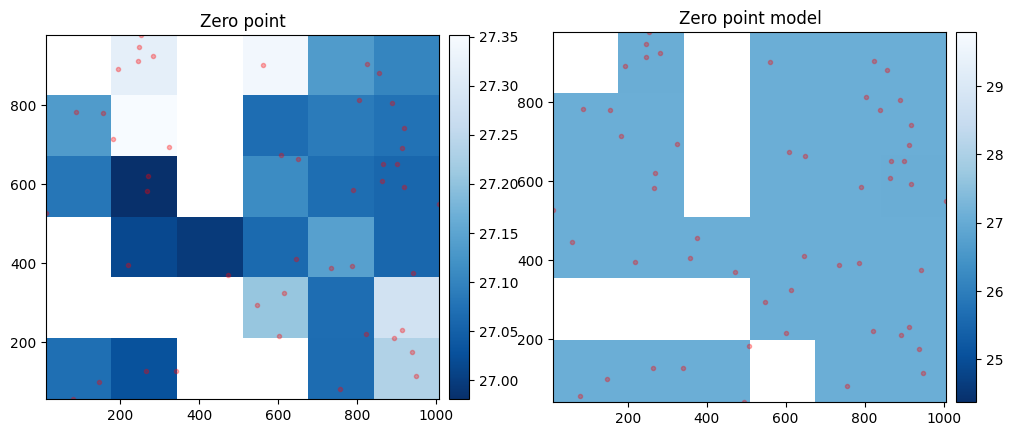

In [26]:
# Zero point (difference between catalogue and instrumental magnitudes for every star) map
plt.subplot(121)
plots.plot_photometric_match(
    m, 
    mode='zero', 
    bins=6, 
    # Whether to show positions of the stars
    show_dots=True, 
    color='red', 
    aspect='equal'
)

plt.title('Zero point')

# Fitted zero point model with second-order spatial polynomial term
plt.subplot(122)
plots.plot_photometric_match(
    m, 
    mode='model', 
    bins=6, 
    show_dots=True, 
    color='red', 
    aspect='equal'
)

plt.title('Zero point model')



## Simple catalogue-based transient detection

Anyway, at this point we already have the detections of all sufficiently isolated and sufficiently bright objects on the frame, as well as an astrometric and photometric calibration for them. 

Some transients may already be detected by comparing the detected objects with catalogue, and selecting the ones that do not have any counterpart there. This approach is limited, as
 - it does not play well with blended objects, as they are often being detected as a single extended thing with centroid separated from the centres of individual components
 - it does not easily allow to detect flares or low-amplitude variability of objects that are present in the catalogue
 
Anyway, let's do it. We have a dedicated routine `pipeline.filter_transient_candidates` that accepts the list of objects, and filters out the following things:
 - flagged ones, i.e. with `obj['flags'] != 0`
 - positionally coincident with stars from provided cataloge table (if `cat != None`)
 - positionally coincident with stars from Vizier catalogues specified as a list of names (if `vizier` list is non-empty)
 - positionally and temporally coincident with Solar system objects from SkyBoT service (if `skybot = True` and `time` is provided, or is present in the object list as a column)
 - positionally coincident with NED objects (if `ned = True`)

As we are already using PanSTARRS as a reference catalogue, let's limit Vizier filtering to variable stars only. And as an input list of candidates, let's just use all detected objects.

In [27]:
# Filtering of transient candidates
candidates = pipeline.filter_transient_candidates(
    obj,
    cat=cat, 
    sr=0.5*fwhm*pixscale,
    # We will check only against Pan-STARRS as our reference catalogue may not be deep enough
    vizier=['ps1'],
    # Filter out any flags except for 0x100 which is isophotal masked
    flagged=True, 
    flagmask=0xfe00,
    verbose=True
)

Candidate filtering routine started with 65 initial candidates and 0.9 arcsec matching radius
64 of them are unflagged
6 of them are not matched with reference catalogue
5 remains after matching with PanSTARRS DR1
5 candidates remaining after filtering


Now we may create cutouts for these surviving candidates and vizualize them, also downloading corresponding cutouts from PanSTARRS itself

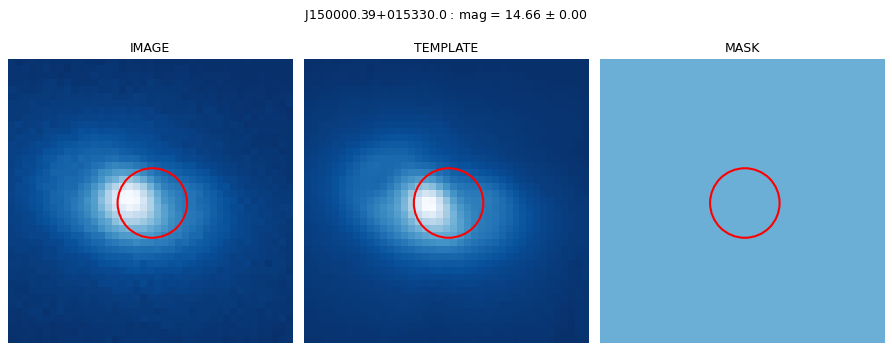

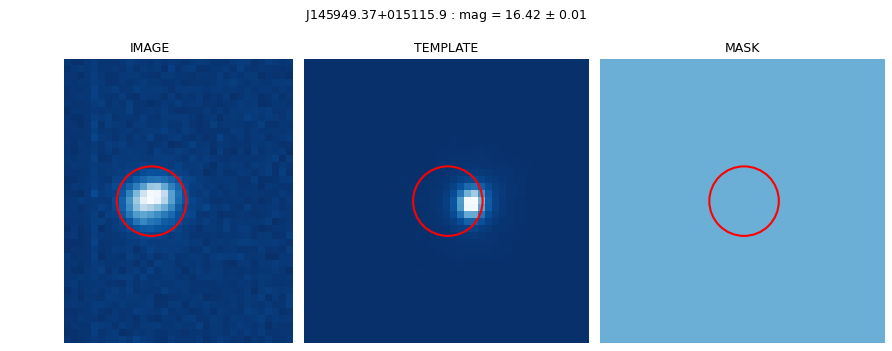

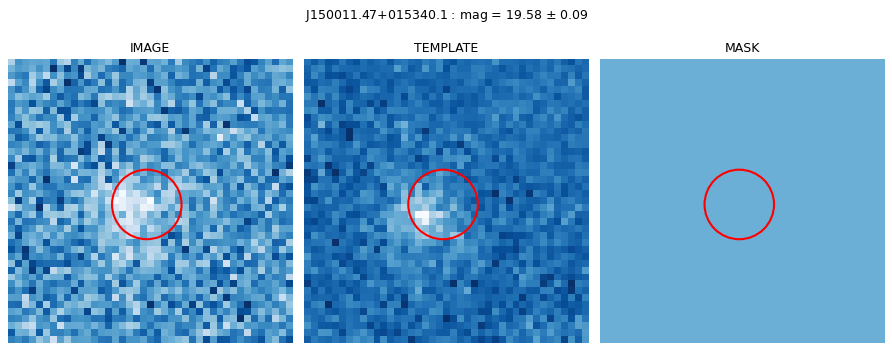

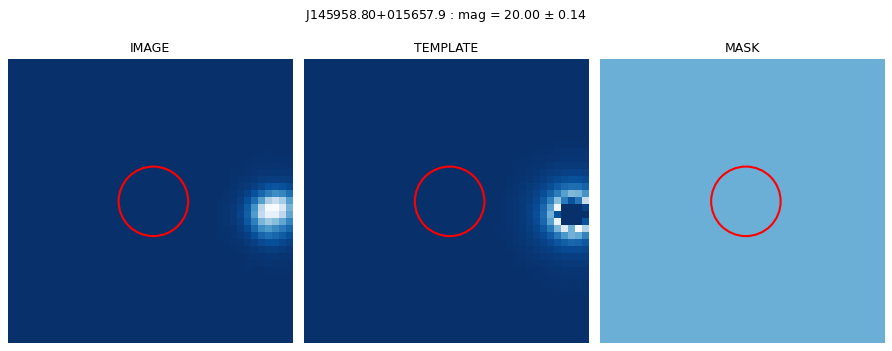

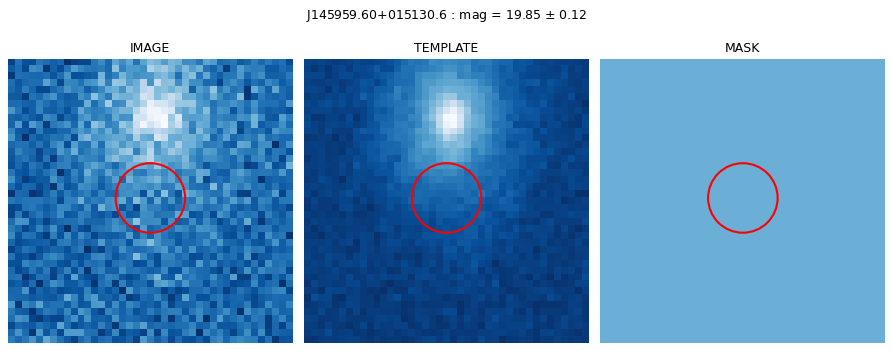

In [28]:
for cand in candidates:
    # Create the cutout from image based on the candidate
    cutout = cutouts.get_cutout(
        # Image
        image, 
        # Candidate - it will use its pixel position to center the cutout
        cand, 
        # Cutout half-size in pixels
        20,
        # Additional planes for the cutout
        mask=mask, 
        # FITS header to include with the cutout - it will automatically adjust WCS there
        header=header
    )
    
    # We did not do image subtraction yet, but we may already
    # directly download the "template" image for this position 
    # from HiPS server - same scale and orientation, but different PSF shape!..
    cutout['template'] = templates.get_hips_image(
        # HiPS survey name - anything from http://aladin.cds.unistra.fr/hips/list goes!
        'PanSTARRS/DR1/r',
        # FITS header with proper WCS and size
        header=cutout['header'],
        # Return only image
        get_header=False 
    )
    
    # Pixel position of the candidate inside the cutout
    x0,y0 = WCS(cutout['header']).all_world2pix(cand['ra'], cand['dec'], 0)
    
    # Now we have three image planes in the cutout - let's display them
    plots.plot_cutout(
        cutout, 
        # Image planes to display - optional, by default displays everything
        planes=['image', 'template', 'mask'],
        # Percentile-based scaling and linear stretching
        qq=[0.5, 99.95], 
        # Intensity stretching, may be 'linear', 'asinh', 'log', 'power' etc
        stretch='power',
        # Mark the candidate position
        mark_x=x0,
        mark_y=y0,
    )
    plt.show()

# Image subtraction

More accurate and stable transient detection is performed using *image subtraction* which is supposed to remove the contribution from all non-transient and non-variable objects in the image, including stars, galaxies, etc.

In addition to what we already have (science image, its mask, its astrometric and photometric calibration) we will need the following to perform the image subtraction:
 - template image, astrometrically aligned with our science image
 - mask for the template
 - noise models for both the template and science images
 

## Templates from public data archives

The template may be some image or coadd from the same instrument that does not contain the transient - e.g. acquired after it already faded, or well before its onset. The latter is how modern time-domain sky surveys handle it - they first collect the templates for all sky regions they will operate upon, and then routinely monitor these parts of the sky. But for smaller instruments you typically do not have prior observations of your sky field. Fortunately, nowadays you may just download sufficiently deep images for nearly any point of the sky from public data archives (but it will be, of course, from different instrument and probably in slightly different filter). We will show how to use this approach to prepare the template for subtraction.

The images may be acquired manually, and then astrometrically aligned with science image using either [SWarp](https://github.com/astromatic/swarp), or Python libraries like [AstroAlign](https://github.com/quatrope/astroalign) or [MontagePy](http://montage.ipac.caltech.edu/docs/montagePy-UG.html).

*STDPipe* contains the convenience routine for downloading the images for both deep coadds and corresponding masks from either [Pan-STARRS](https://outerspace.stsci.edu/display/PANSTARRS/Pan-STARRS1+data+archive+home+page) or [DESI Legacy Survey](https://www.legacysurvey.org), and its automatic re-projection (using SWarp) onto the pixel grid of science image. 

In [29]:
# Get r band image from Pan-STARRS with the same resolution and orientation
tmpl = templates.get_survey_image(
    # Photometric band - one of 'g', 'r', 'i', 'z', 'y' for Pan-STARRS
    band='i',
    # One of 'image' or 'mask'
    ext='image',
    # Either 'ps1' for Pan-STARRS or 'ls' for Legacy Survey
    survey='ps1',
    # pixel grid defined by WCS and image size
    wcs=wcs,
    width=image.shape[1],
    height=image.shape[0],
    verbose=True
)

# Also get proper mask
tmask = templates.get_survey_image(
    # Photometric band - one of 'g', 'r', 'i', 'z', 'y' for Pan-STARRS
    band='i',
    # One of 'image' or 'mask'
    ext='mask',
    # Either 'ps1' for Pan-STARRS or 'ls' for Legacy Survey
    survey='ps1',
    # pixel grid defined by WCS and image size
    wcs=wcs,
    width=image.shape[1],
    height=image.shape[0],
    verbose=True
)
# Mask bits for Pan-STARRS are documented at https://outerspace.stsci.edu/display/PANSTARRS/PS1+Pixel+flags+in+Image+Table+Data
# We will exclude pixels with any non-zero mask value
tmask = tmask > 0
# We will also mask the regions of the template filled with NaNs
tmask |= np.isnan(tmpl)

Cache location not specified, falling back to /tmp/ps1
rings.v3.skycell.1378.042.stk.i.unconv.fits already downloaded
rings.v3.skycell.1378.052.stk.i.unconv.fits already downloaded
Will run SWarp like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/swarp -VERBOSE_TYPE NORMAL -IMAGEOUT_NAME /tmp/swarpw3ynx3g7/coadd.fits -WEIGHTOUT_NAME /tmp/swarpw3ynx3g7/coadd.weights.fits -c /tmp/swarpw3ynx3g7/empty.conf -XML_NAME /tmp/swarpw3ynx3g7/swarp.xml -VMEM_DIR /tmp/swarpw3ynx3g7 -RESAMPLE_DIR /tmp/swarpw3ynx3g7 -SUBTRACT_BACK N -FSCALASTRO_TYPE VARIABLE /tmp/ps1/rings.v3.skycell.1378.042.stk.i.unconv.fits /tmp/ps1/rings.v3.skycell.1378.052.stk.i.unconv.fits


> 
----- SWarp 2.38.0 started on 2023-08-29 at 16:33:47 with 64 threads

> Examining input data ...
> Looking for rings.v3.skycell.1378.042.stk.i.unconv.fits ...
> Looking for rings.v3.skycell.1378.052.stk.i.unconv.fits ...
> Creating NEW output image ...

> WARNING: FITS header data read in /tmp/swarpw3ynx3g7/coadd.head


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection

> Creating NEW weight-map ...
> 
------- Output File coadd.fits:
    "no ident"  WEIGHTED  EXT. HEADER  1024x1024  32 bits (floats)
    Center: 15:00:01.85 +01:54:20.4   6.46'x6.46'  Scale: 0.3783 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File rings.v3.skycell.1378.042.stk.i.unconv.fits:
    "no ident"  unweighted  no ext. header  6240x6243  32 bits (floats)
    Center: 15:00:00.08 +01:47:58.3   26'x26'  Scale: 0.2499 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom

SWarp run successfully in 1.31 seconds
Cache location not specified, falling back to /tmp/ps1
rings.v3.skycell.1378.042.stk.i.unconv.mask.fits already downloaded
rings.v3.skycell.1378.052.stk.i.unconv.mask.fits already downloaded
The images will be handled as integer flags
Will run SWarp like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/swarp -VERBOSE_TYPE NORMAL -IMAGEOUT_NAME /tmp/swarpjcr283yr/coadd.fits -WEIGHTOUT_NAME /tmp/swarpjcr283yr/coadd.weights.fits -c /tmp/swarpjcr283yr/empty.conf -XML_NAME /tmp/swarpjcr283yr/swarp.xml -VMEM_DIR /tmp/swarpjcr283yr -RESAMPLE_DIR /tmp/swarpjcr283yr -SUBTRACT_BACK N -FSCALASTRO_TYPE VARIABLE -RESAMPLING_TYPE FLAGS -COMBINE_TYPE AND /tmp/ps1/rings.v3.skycell.1378.042.stk.i.unconv.mask.fits /tmp/ps1/rings.v3.skycell.1378.052.stk.i.unconv.mask.fits



> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING: Significant inaccuracy likely to occur in projection


> WARNING

SWarp run successfully in 0.57 seconds


-------------- Co-adding frames            
Maximum overlap density: 1 frame
> Preparing line:      1 / 1024   
> Reading   line:      1 / 1024   
> Co-adding line:      1 / 1024   
> Writing   line:      1 / 1024   
> Closing files ...
> 
> All done (in 0.6 s)


Text(0.5, 1.0, 'Template mask')

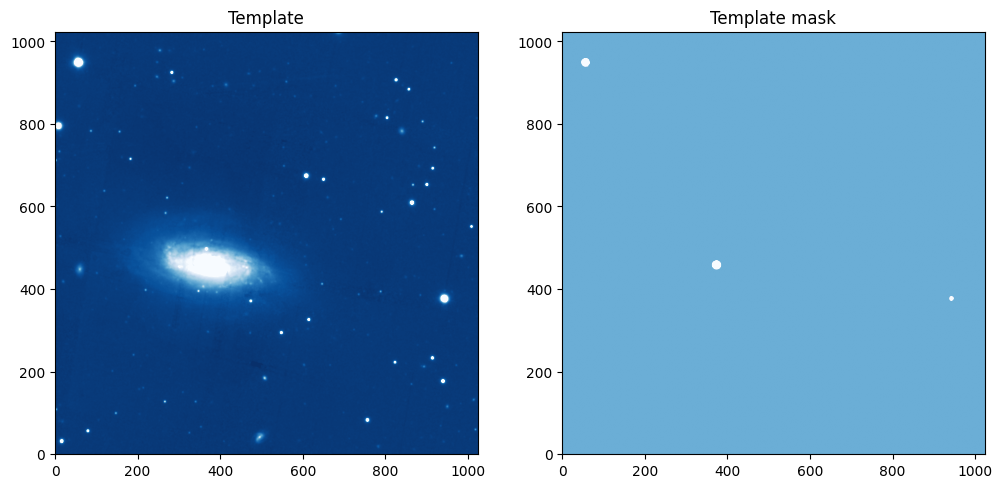

In [30]:
plt.subplot(121)
plots.imshow(tmpl, show_colorbar=False)
plt.title('Template')

plt.subplot(122)
plots.imshow(tmask, show_colorbar=False)
plt.title('Template mask')


### Exercise

Plot the template alongside with original image, and see how much deeper and sharper is it. Or is it not?..

Text(0.5, 1.0, 'Template')

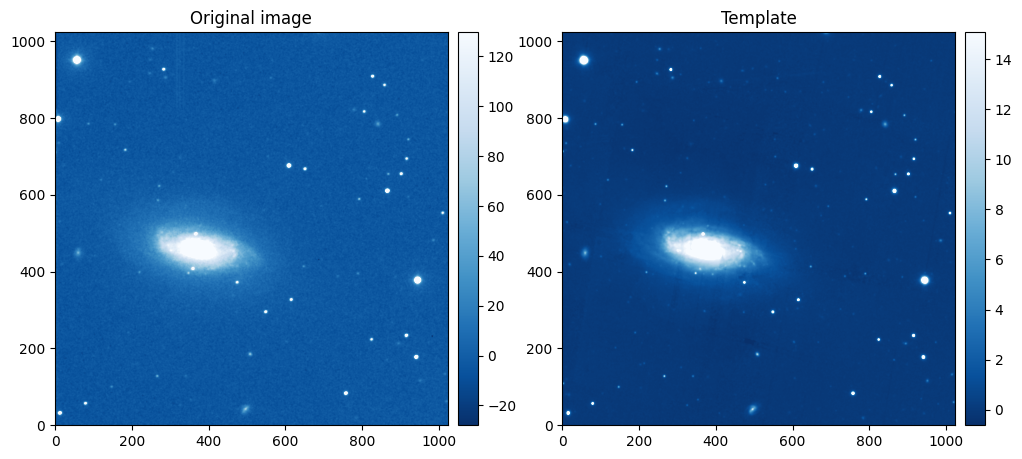

In [31]:
ax = plt.subplot(121)
plots.imshow(image, interpolation='bicubic')
plt.title('Original image')

plt.subplot(122, sharex=ax, sharey=ax) # So that zoom works for both images
plots.imshow(tmpl, interpolation='bicubic')
plt.title('Template')

# plt.xlim(800, 1200)
# plt.ylim(800, 1200)

# Subtracting the images with HOTPANTS

We will show how to use [HOTPANTS](https://github.com/acbecker/hotpants) (which stands for "High Order Transform of PSF ANd Template Subtraction") code for image subtraction. It implements a variant of [Alard and Lupton (1998)](https://ui.adsabs.harvard.edu/abs/1998ApJ...503..325A/abstract) algorithm that convolves one of the images with the kernel composed of several simple basis functions, so that it matches the resolution (and flux scale) of the second image. 

Image subtraction with HOTPANTS is implemented in `subtraction.run_hotpants` routine, that implements the following logic on top of just running `hotpants` binary:
 - finding optimal convolutuon kernel sizes based on image and template FWHM (three Gaussians, with sizes 0.5, 1 and 2 `sigma_match`, where `sigma_match = sqrt(image_fwhm ** 2 - template_fwhm ** 2) / 2.35`, and with the orders of corresponding polynomials 6, 4 and 2).
 - filling in necessary parameters like min/max pixel values, etc
     - also, all parameters may be overwritten or added by passing them through `extra` argument, allowing full control over the code
 - (optionally) building noise models for the image and template based on their background statistics and gain, so that they may be e.g. background-subtracted
     - noise model is again based on background rms + Poisson contribution from the object flux
 - (optionally) constructing the list of stamp positions used for fitting the convolution kernel based on user-supplied list of coordinates (e.g. detected and unflagged objects)

By default, it will convolve the template, so that the difference image will have the same resolution and flux scaling as the original science image. This way, we may directly use our photmetric zero point for the aperture photometry results derived on difference image. For it to work properly, the template has to be sharper (with smaller FWHM) than the image itself.

HOTPANTS computes, and the routine optionally returns - along with difference image - the template convolved with the kernel (so supposedly matching the science image resolution), noise-scaled difference image, and the error model. The latters may be used to assess the significance of detections.

***
In order to ease the subtraction, we will need to remove any additional inhomogeneities in the image - caused e.g. by non-uniform sky background due to Moon or some reflections. For that, we will subtract the smoothly varying backgrounds, computed with the same grid size, from both the image and template, so that the impact on actual large-scale structures (nearby galaxies?..) was similar.

In [32]:
# Prepare for the subtraction by estimating image and template backgrounds
bg = photutils.Background2D(
    image,
    # Grid size in pixels
    128,
    mask=mask
).background

template_bg = photutils.Background2D(
    tmpl, 
    # Grid size in pixels
    128,
    mask=tmask
).background

/tmp/ipykernel_598069/843852187.py:2: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  bg = photutils.Background2D(
/tmp/ipykernel_598069/843852187.py:9: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  template_bg = photutils.Background2D(


In [33]:
# We also need to estimate FWHM in the template
tobj = photometry.get_objects_sextractor(
    tmpl, 
    mask=tmask, 
    gain=1e6,
)

template_fwhm = np.median(tobj['fwhm'][tobj['flags'] == 0])
print('Template FWHM is %.1f pixels' % template_fwhm)

Template FWHM is 4.4 pixels


### Exercise

Again, check the accuracy of FWHM estimation. It is important, as the sizes of convolution kernel basis functions depend on it!

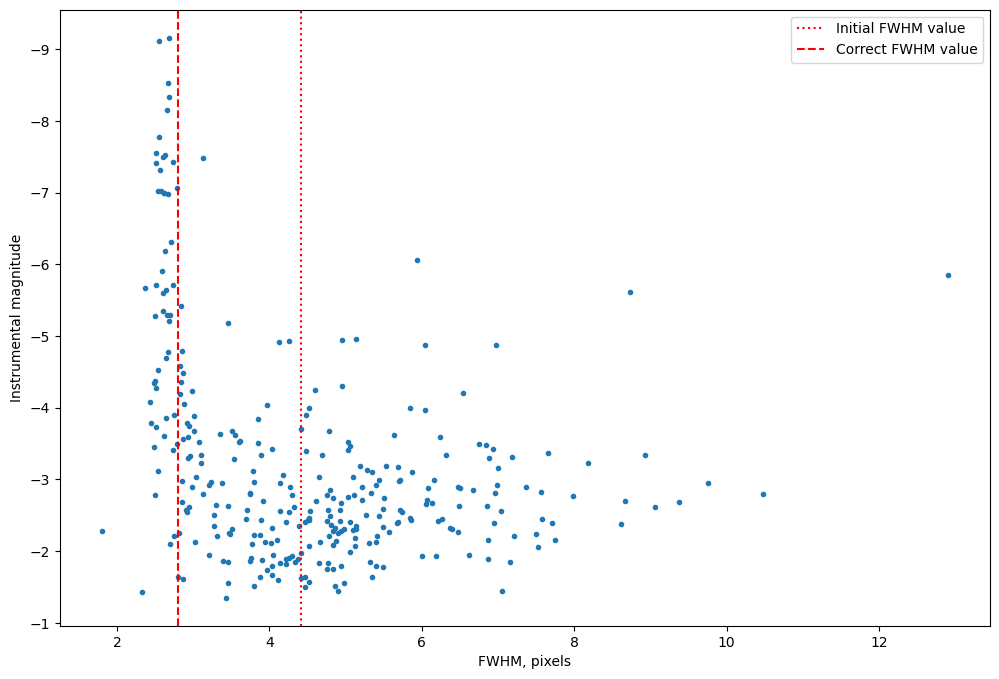

In [34]:
# Exclude saturated objects etc
idx = tobj['flags'] == 0

# Also exclude lower-quality objects
idx1 = idx & (tobj['magerr'] < 1/20) 
template_fwhm = np.median(tobj['fwhm'][idx1])

#template_fwhm = ????

plt.plot(tobj['fwhm'][idx], tobj['mag'][idx], '.')
plt.axvline(np.median(tobj['fwhm'][idx]), ls=':', color='red', label='Initial FWHM value')
plt.axvline(template_fwhm, ls='--', color='red', label='Correct FWHM value')
plt.gca().invert_yaxis()
plt.xlabel('FWHM, pixels')
plt.ylabel('Instrumental magnitude')
plt.legend()

Now, the main function! It has a lot of parameters - see https://stdpipe.readthedocs.io/en/latest/subtraction.html#running-image-subtraction for the full list. And remember - image subtraction is an art, not proper science! :-)

In [35]:
# Run the subtraction and get all possible result planes
diff,conv,sdiff,ediff = subtraction.run_hotpants(
    # Background-subtracted image
    image - bg, 
    # Background-subtracted template
    tmpl - template_bg, 
    
    # Masks
    mask=mask, 
    template_mask=tmask,
    
    # FWHMs for the convolution kernel size
    image_fwhm=fwhm, 
    template_fwhm=template_fwhm, 
    
    # Parameters for the noise model
    image_gain=gain, 
    template_gain=1e6, # Assume negligibly small Poissonian noise
    
    # Estimate noise model for the image automatically, using background and Poissonian noise
    err=True, 
    template_err=True,
    
    # Output parameters
    get_convolved=True, # Template convolved with the kernel
    get_scaled=True, # Noise-scaled difference image
    get_noise=True, # Error model for the difference image
    
    # Extra parameters to be passed to HOTPANTS (optional)
    # e.g to split it into sub-images for independent processing:
    #extra={'okn':True, 'nrx':2, 'nry':2},
    # or, to manually specify the basis functions (see documentation)
    #extra={'ng':[4, 6, 0.5, 4, 1.0, 2, 2.0, 2, 4.0]},
    
    # We may also provide the list of positions for deriving the kernel - otherwise 
    # it will try to place them automatically, which may be suboptimal sometimes
    #obj=obj[obj['flags']==0],

    verbose=True,
)

# Bad pixels as marked by HOTPANTS
dmask = diff == 1e-30 

Building noise model from the image
Building noise model from the template
Will run HOTPANTS like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/hotpants -inim /tmp/hotpants27hfqmj_/image.fits -tmplim /tmp/hotpants27hfqmj_/template.fits -outim /tmp/hotpants27hfqmj_/diff.fits -savexy /tmp/hotpants27hfqmj_/stamps.reg -imi /tmp/hotpants27hfqmj_/imask.fits -tmi /tmp/hotpants27hfqmj_/tmask.fits -il -99.95049379960764 -iu 28102.089325114142 -tl -2.4420249132992744 -tu 2285.267945153479 -tuk 2285.267945153479 -n i -allm -c t -hki -nrx 1 -nry 1 -ko 0 -bgo 0 -v 2 -ini /tmp/hotpants27hfqmj_/err.fits -tni /tmp/hotpants27hfqmj_/terr.fits -ng 3 6 0.7808568465660234 4 1.5617136931320468 2 3.1234273862640936 -r 14 -rss 19 -ig 1.0 -tg 1000000.0


Doing : /tmp/hotpants27hfqmj_/image.fits -
        /tmp/hotpants27hfqmj_/template.fits =
        /tmp/hotpants27hfqmj_/diff.fits
   Good templ data : -2.4 -> 2285.3
   Good image data : -100.0 -> 28102.1
Mallocing massive amounts of memory...
Region 0 pixels            : 1:1024,1:1024
 Vector Indices (buffered) : 0:1023,0:1023
 Vector Indices (good data): 0:1023,0:1023
Allocating stamps...
Build stamp  : t    0 i    0 (grid coord  0  0)
    Stamp in region : 0:72,0:72
    Tmpl  xs :   36 ys :   36  (sky,dsky = 0.0,0.2)
    ...only found 0 good substamps by autosearch
    NO good pixels, skipping...
    Tmpl     : scnt =  0 nss =  0
    templ: 0 substamps
Build stamp  : t    0 i    0 (grid coord  1  0)
    Stamp in region : 102:174,0:72
    Tmpl  xs :  138 ys :   36  (sky,dsky = -0.0,0.2)
    ...only found 0 good substamps by autosearch
    NO good pixels, skipping...
    Tmpl     : scnt =  0 nss =  0
    templ: 0 substamps
Build stamp  : t    0 i    0 (grid coord  2  0)
    Stamp in re

HOTPANTS run succeeded
20 stamps used


 Sum Kernel at 0,0: 7.920286
 Sum Kernel at 1023,1023: 7.920286
 Using Kernel Sum = 7.920286

 Creating and writing output images...
   FINAL Mean sig:  0.852 stdev:  0.029
 Getting diffim stats for GOOD pixels : 
   Mean   : -0.09
   Median : -0.16
   Mode   : -0.87
   Stdev  : 9.43
   FWHM   : 9.50
   lFWHM  : 9.47
 Getting noiseim stats for GOOD pixels : 
   Mean   : 9.77
   Median : 9.71
   Mode   : 9.54
   Stdev  : 0.32
   FWHM   : 0.33
   lFWHM  : 0.28
 Emperical / Expected Noise for GOOD pixels = 0.97
 X2NORM = 0.88

 Getting diffim stats for OK pixels : 
   Mean   : 7.57
   Median : 6.79
   Mode   : 5.79
   Stdev  : 14.75
   FWHM   : 12.72
   lFWHM  : 12.14
 Getting noiseim stats for OK pixels : 
   Mean   : 20.65
   Median : 11.78
   Mode   : 9.67
   Stdev  : 12.74
   FWHM   : 17.89
   lFWHM  : 2.10
 Emperical / Expected Noise for OK pixels = 0.71

Region 0 finished

SUCCESS


Let's see the results. We will now plot the noise-scaled difference image, where every pixel value is divided by its estimated error - so, it represents the significance of the residual. 

Text(0.5, 1.0, 'Noise-scaled difference image')

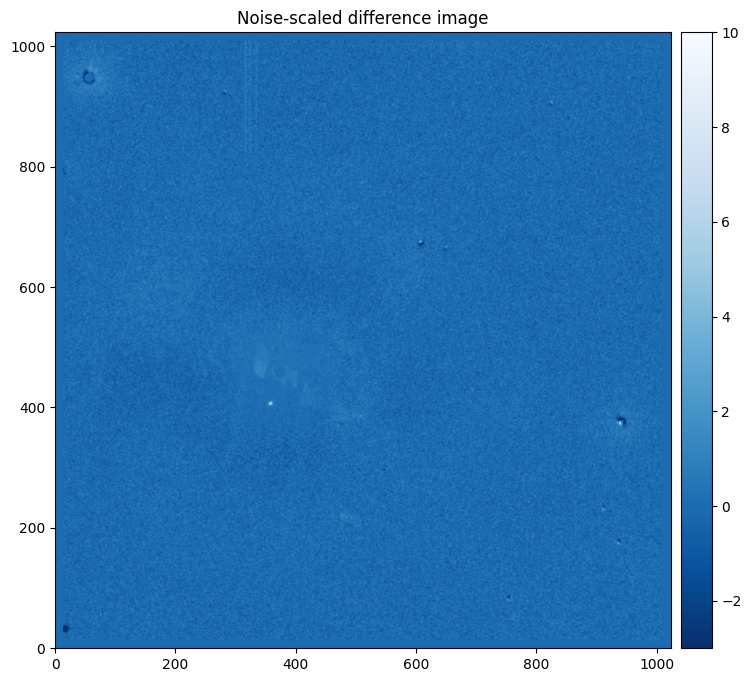

In [36]:
# Set to zero all masked pixels
sdiff[mask | tmask | dmask] = 0

plots.imshow(sdiff, vmin=-3, vmax=10)
plt.title('Noise-scaled difference image')

# plt.xlim(800, 1200)
# plt.ylim(800, 1200)

Not every star got fully subtracted - these are mostly saturated objects that are masked. They will be rejected on the next step.

# Transient detection in difference image

Transient detection on difference image differs from the one we did on original image in two ways:
 - there are much less remaining sources
 - most of them are subtraction artefacts that have different PSF shape, so may be filtered out
 - we know the noise model for the difference image
 
Knowing noise model also helps filtering out subtraction artefacts as they mostly happen in high-noise regions (inside stellar footprints).

So we will pass this noise model to SExtractor to be used for transient detection. We will also show how to pass extra parameters to SExtractor to get extra fields in the output, inspect checkimages, etc. 

### Exercise

Plot the difference image alongside with original image, and see whether the stars are actually being subtracted. What kinds of problems are there?

Text(0.5, 1.0, 'Difference')

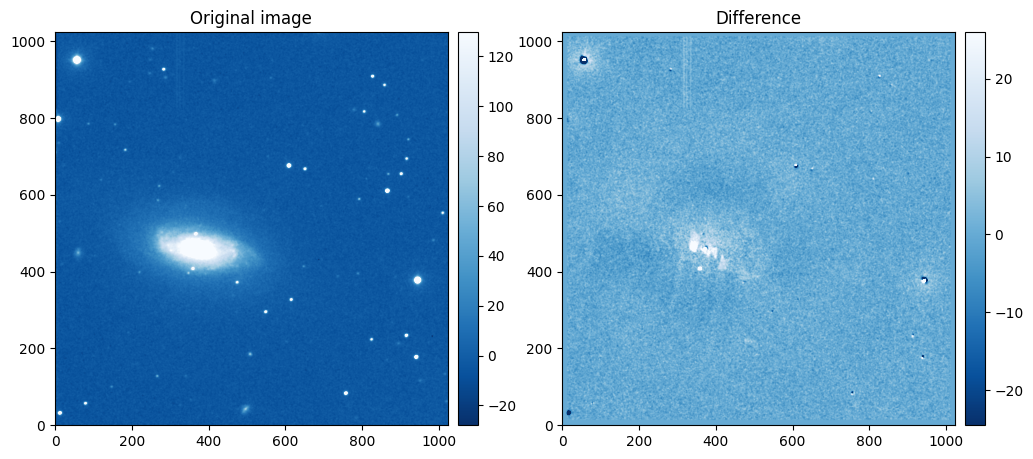

In [37]:
ax = plt.subplot(121)
plots.imshow(image, interpolation='bicubic')
plt.title('Original image')

plt.subplot(122, sharex=ax, sharey=ax) # So that zoom works for both images
plots.imshow(diff, interpolation='bicubic')
plt.title('Difference')

# plt.xlim(800, 1200)
# plt.ylim(800, 1200)

In [38]:
# Run SExtractor on difference image with custom noise model, 
# returning object footprints and some additional fields
sobj,segm = photometry.get_objects_sextractor(
    # Operate on difference image
    diff, 
    # Combined mask
    mask=mask | tmask | dmask, 
    # Error model
    err=ediff,
    # Exclude everything closer than 20 pixels to the edge
    edge=20,
    wcs=wcs, 
    aper=5.0,
    # Get extra object parameters
    extra_params=[
        'NUMBER', # Object number, the same as used in segmentation map
    ], 
    # Pass extra configuration parameters to SExtractor
    extra={}, 
    # Also return the segmentation map
    checkimages=[
        'SEGMENTATION'
    ], 
    verbose=True)

# Perform forced aperture photometry, again with custom noise model and forced zero background level
sobj = photometry.measure_objects(
    sobj, 
    # Operate on difference image
    diff, 
    # Combined mask
    mask=mask | tmask | dmask, 
    # Known noise model for difference image
    err=ediff,
    # Here we use the same parameters as for forced photometry on original image
    fwhm=fwhm, # It will be used for scaling the aperture radius
    gain=gain, # It will be used for computing Poissonian noise contribution
    aper=1.0, # In FWHM units
    bkgann=[5, 7], # In FWHM units
    # Filter out everything with S/N < 5
    sn=5, 
    verbose=True
)

# The difference is in original image normalization, so we know photometric zero point
sobj['mag_calib'] = sobj['mag'] + m['zero_fn'](
    sobj['x'], 
    sobj['y']
)
sobj['mag_calib_err'] = np.hypot(
    sobj['magerr'], m['zero_fn'](
        sobj['x'], 
        sobj['y'], 
        get_err=True
    )
)

print(len(sobj), 'transient candidates found in difference image')

Will run SExtractor like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/sex /tmp/sexofbjtj06/image.fits -c /tmp/sexofbjtj06/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1 -DETECT_THRESH 2.0 -WEIGHT_TYPE MAP_RMS -MASK_TYPE NONE -SATUR_LEVEL 1295.68994140625 -WEIGHT_IMAGE /tmp/sexofbjtj06/errors.fits -FLAG_IMAGE /tmp/sexofbjtj06/flags.fits -PHOT_APERTURES 10.0 -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME /tmp/sexofbjtj06/SEGMENTATION.fits -PARAMETERS_NAME /tmp/sexofbjtj06/cfg.param -CATALOG_NAME /tmp/sexofbjtj06/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
Estimating global background with 64x64 mesh
Subtracting global background: median -0.4 rms 0.59
Using user-provided noise map: median 9.7 rms 2.60
Scaling aperture radii with FWHM 4.6 pix
Using aperture radius 4.6 pixels
Using local background annulus between 23.1 and 32.3 pixels
Filtering out measurements with S/N < 5.0
6 transient candidates found in difference image


In [39]:
# Filtering of transient candidates
candidates = pipeline.filter_transient_candidates(
    sobj,
    # Reject entries present in the reference catalogue
    #cat=cat, 
    sr=0.5*fwhm*pixscale,
    # We will not filter any catalogues, maybe except for AAVSO VSX
    #vizier=['vsx'], 
    # Filter out any flags except for 0x100 which is isophotal masked
    flagged=True, flagmask=0xfe00,
    verbose=True
)

Candidate filtering routine started with 6 initial candidates and 0.9 arcsec matching radius
2 of them are unflagged
2 candidates remaining after filtering


Candidate 0 with mag = 17.75 +/- 0.05 at x/y = 358.0 406 and RA/Dec = 224.9962 1.8899


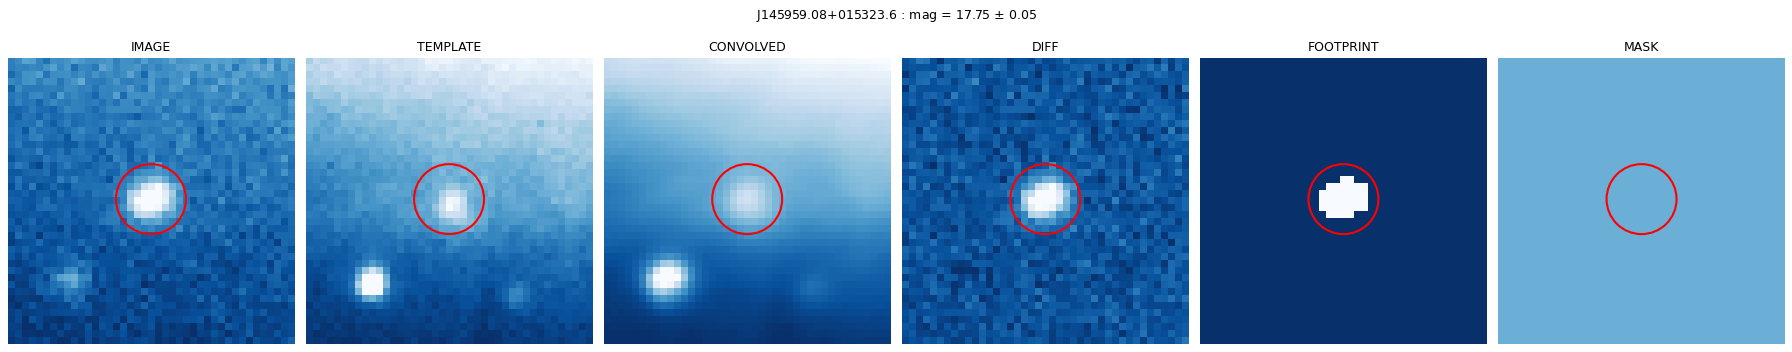

Candidate 1 with mag = 20.08 +/- 0.17 at x/y = 61.7 961 and RA/Dec = 225.0536 1.8570


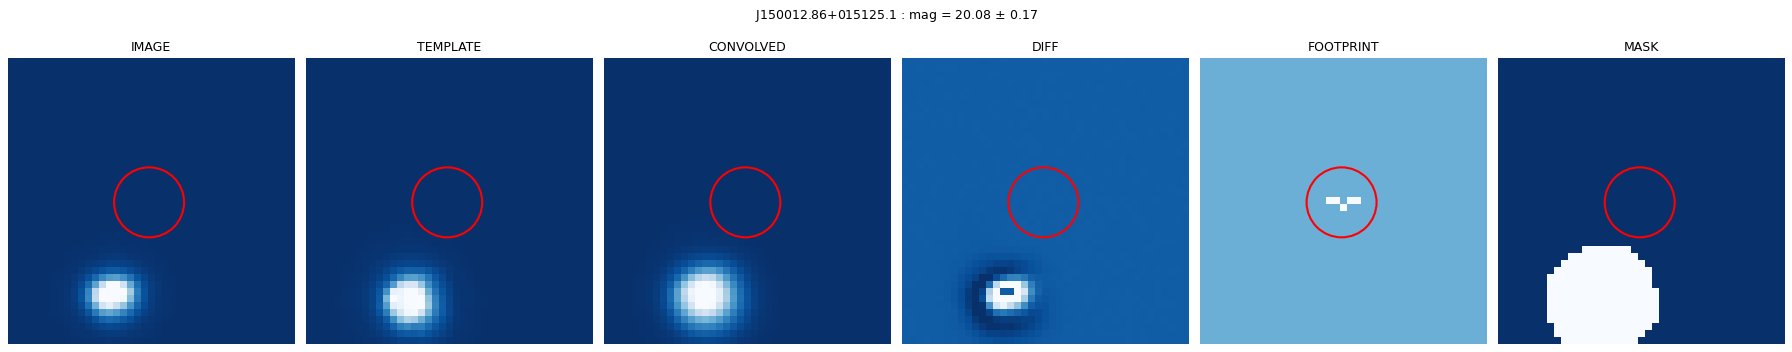

In [40]:
for i,cand in enumerate(candidates):
    print('Candidate %d with mag = %.2f +/- %.2f at x/y = %.1f %.1d and RA/Dec = %.4f %.4f' 
          % (i, cand['mag_calib'], cand['mag_calib_err'], cand['x'], cand['y'], cand['ra'], cand['dec']))

    cutout = cutouts.get_cutout(
        image, 
        cand, 
        20, # You may vary the cutout size to better see the regions around the source
        mask=mask | tmask | dmask, 
        diff=diff, 
        template=tmpl, 
        convolved=conv, 
        err=ediff, 
        footprint=(segm == cand['NUMBER']), 
        header=header, 
        filename=filename, 
    )

    # Pixel position of the candidate inside the cutout
    x0,y0 = WCS(cutout['header']).all_world2pix(cand['ra'], cand['dec'], 0)


    plots.plot_cutout(
        cutout, 
        planes=['image', 'template', 'convolved', 'diff', 'footprint', 'mask'], 
        qq=[0.5, 99.5], 
        stretch='linear',
        # Mark the candidate position
        mark_x=x0,
        mark_y=y0,
    )

    plt.show()

### Exercise

Try to disable catalogue-based candidate filtering and see how they actually look like. Also, try to play with subtraction parameters. Try to download the "wrong" template - e.g. from different filter, and see how it impacts the subtraction.

# Zackay, Ofek and Gal-Yam (ZOGY) method of image subtraction (optional)

Below I will show how to use one more image subtraction method that is being widely used nowadays. It is often called ZOGY, after the names of its authors, and was first published in [Zackay, Ofek and Gal-Yam (2016)](http://dx.doi.org/10.3847/0004-637X/830/1/27). The method itself does not fit for anything, and thus it requires pre-determined PSFs for both image and template, along with their relative flux scale. Then it both performs the subtraction (basically, by convolving the image with template PSF, and the template - with image PSF, thus matching their resolutions), and provides statistically well-defined estimators for the significance of point source detections in every point of the image.

To use the method, we will need to get the PSFs. We will use [PSFEx](https://github.com/astromatic/psfex) for it, again through the wrapper, as documented at https://stdpipe.readthedocs.io/en/latest/psf.html

In [41]:
image_psf,image_obj = psf.run_psfex(
    image, 
    mask=mask, 
    aper=3.0*fwhm, 
    gain=gain,
    get_obj=True,
    verbose=True
)

# Normalized PSF stamp with original image resolution
image_psf_stamp = psf.get_psf_stamp(image_psf)

Extracting PSF using vignette size 84 x 84 pixels
Will run SExtractor like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/sex /tmp/psfexbo05hyi6/image.fits -c /tmp/psfexbo05hyi6/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.0 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 27817.931640625 -FLAG_IMAGE /tmp/psfexbo05hyi6/flags.fits -PHOT_APERTURES 27.719684600830078 -PARAMETERS_NAME /tmp/psfexbo05hyi6/cfg.param -CATALOG_NAME /tmp/psfexbo05hyi6/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
Will run PSFEx like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/psfex /tmp/psfexbo05hyi6/out.cat -c /tmp/psfexbo05hyi6/empty.conf -VERBOSE_TYPE QUIET -CHECKPLOT_TYPE NONE -CHECKIMAGE_TYPE NONE -PSFVAR_DEGREES 0 -WRITE_XML N
PSFEx run succeeded
Loading PSF model from /tmp/psfexbo05hyi6/out.psf
PSF model 25 x 25 pixels, FWHM 4.8 pixels, sampling 1.01, degree 0



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



In [42]:
template_psf,template_obj = psf.run_psfex(
    tmpl, 
    mask=tmask, 
    aper=3.0*template_fwhm, 
    gain=1e6,
    get_obj=True,
    verbose=True
)

# Normalized PSF stamp with original template resolution
template_psf_stamp = psf.get_psf_stamp(template_psf)

Extracting PSF using vignette size 51 x 51 pixels
Will run SExtractor like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/sex /tmp/psfexerth8937/image.fits -c /tmp/psfexerth8937/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1000000.0 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 2263.584228515625 -FLAG_IMAGE /tmp/psfexerth8937/flags.fits -PHOT_APERTURES 16.837260246276855 -PARAMETERS_NAME /tmp/psfexerth8937/cfg.param -CATALOG_NAME /tmp/psfexerth8937/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
Will run PSFEx like that:
/ltzfs/ASTRO101/anaconda3/envs/astro101/bin/psfex /tmp/psfexerth8937/out.cat -c /tmp/psfexerth8937/empty.conf -VERBOSE_TYPE QUIET -CHECKPLOT_TYPE NONE -CHECKIMAGE_TYPE NONE -PSFVAR_DEGREES 0 -WRITE_XML N
PSFEx run succeeded
Loading PSF model from /tmp/psfexerth8937/out.psf
PSF model 25 x 25 pixels, FWHM 3.3 pixels, sampling 0.70, degree 0



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



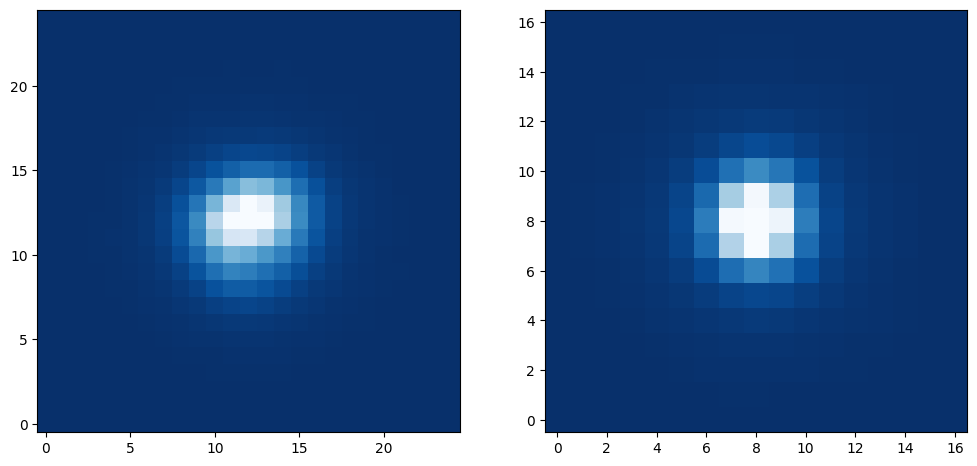

In [43]:
plt.subplot(121)
plots.imshow(image_psf_stamp, show_colorbar=False)
plt.subplot(122)
plots.imshow(template_psf_stamp, show_colorbar=False)

Now we have to get the relative flux scale of the images. We will use object lists returned by `run_psfex` above - they contains the fluxes in large apertures, and thus may be used for it (beware of nearby sources though!)

Naive ZP is 2.3466158
Robust ZP is 2.3466158
Estimated initial template flux scale Fr = 0.122


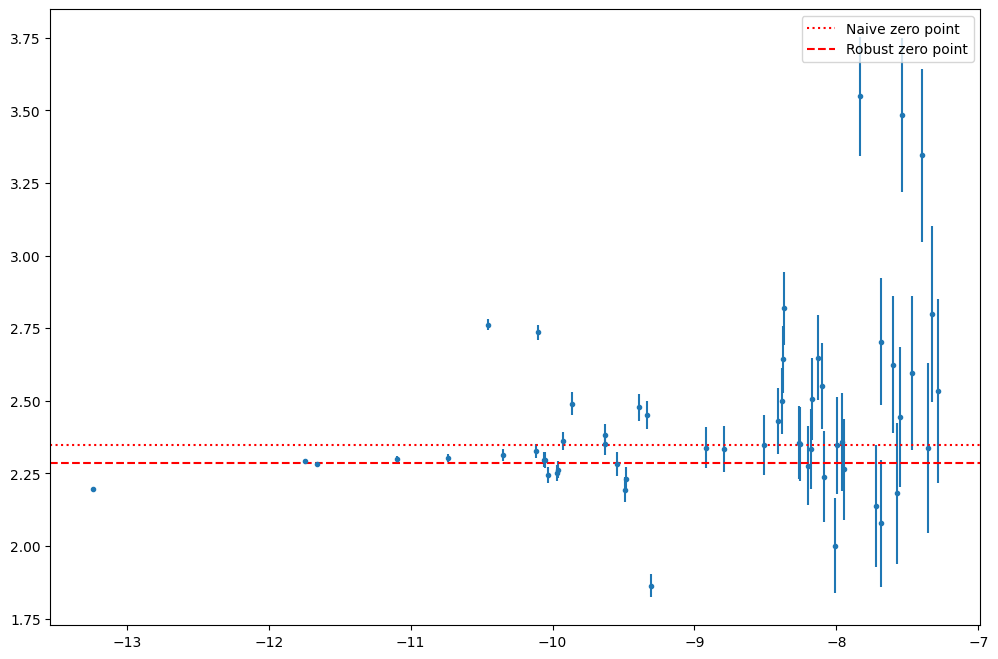

In [44]:
# Use half FWHM radius for matching
sr = 0.5*max(image_psf['fwhm'], template_psf['fwhm'])

iidx,tidx,_ = astrometry.planar_match(
    image_obj['x'], image_obj['y'],
    template_obj['x'], template_obj['y'],
    sr
)

# Exclude all flagged objects
fidx = (image_obj['flags'][iidx] & 0x100) == 0
fidx &= (template_obj['flags'][tidx] & 0x100) == 0

if np.sum(fidx) < 5:
    print('Not enough matched points for scale estimation!')
    
# Compute photometric zero point shift between two object lists
ZP = template_obj['mag'][tidx][fidx] - image_obj['mag'][iidx][fidx]
dZP = np.hypot(image_obj['magerr'][iidx][fidx], template_obj['magerr'][tidx][fidx])

# Naive estimation
ZP_naive = np.median(ZP)
print('Naive ZP is', ZP_naive)

# More accurate - weighted robust regression
import statsmodels.api as sm
X = np.ones_like(ZP).T
C = sm.RLM(ZP / dZP, (X.T / dZP).T).fit()
ZP_robust = C.params[0]
print('Robust ZP is', ZP_naive)

scale = 10**(-0.4*ZP_robust)
print("Estimated initial template flux scale Fr = %.3g" % scale)

plt.errorbar(
    image_obj['mag'][iidx][fidx], 
    ZP,
    dZP,
    fmt='.'
)
plt.axhline(ZP_naive, color='red', ls=':', label='Naive zero point')
plt.axhline(ZP_robust, color='red', ls='--', label='Robust zero point')
plt.legend()

The cell below contains an implementaion of image subtraction algorithm, as described in [ZOGY paper](http://dx.doi.org/10.3847/0004-637X/830/1/27). Equation numbers, variable names and comments directly refer to the paper. Feel free to read it, the paper is really interesting! :-)

*STDPipe* also contains a variant of this code, with some additional things (like fitting for flux scale and offset) implemented. The code below should be equivalent to 
```
D, S_corr = subtraction.run_zogy(image - bg, tmpl - template_bg, mask=mask, template_mask=tmask, image_psf=image_psf, template_psf=template_psf, image_gain=gain, template_gain=1e6, scale=scale, fit_scale=False, fit_shift=False)
```

In [45]:
# Drop-in replacement for numpy.fft which is supposedly faster
# import pyfftw.interfaces.numpy_fft as fft
from numpy import fft

image_bg = photutils.Background2D(image, 64, mask=mask)
template_bg = photutils.Background2D(tmpl, 64, mask=tmask)

# Subtract backgrounds
N = image - image_bg.background
R = tmpl - template_bg.background
# Set to zero the regions where we have no usable data
N[mask] = 0
R[tmask] = 0

# Image noise model
U_N = image_bg.background_rms
U_N = np.sqrt(U_N ** 2 + np.abs(N) / gain)
SN = image_bg.background_rms_median

# Template noise model
U_R = template_bg.background_rms
#U_R = np.sqrt(U_R ** 2 + np.abs(R) / template_gain) 
SR = template_bg.background_rms_median

# Artificially assign large uncertainty to the regions we set to zero
U_N[mask] = np.nanmax(U_N)
U_R[tmask] = np.nanmax(U_R)

# PSF stamps
P_N_small = psf.get_psf_stamp(image_psf)
P_R_small = psf.get_psf_stamp(template_psf)

Fn = 1 # Fixed, so that the difference will be in science image flux scale
Fr = scale 

# Expected astrometric errors
dx = 0.25
dy = 0.25

# Place PSF at the center of image with same size as new / reference
P_N = np.zeros_like(N)
P_R = np.zeros_like(R)
idxN = tuple([slice(int(N.shape[0]/2) - int(P_N_small.shape[0]/2),
                    int(N.shape[0]/2) + int(P_N_small.shape[0]/2) + 1),
              slice(int(N.shape[1]/2) - int(P_N_small.shape[1]/2),
                    int(N.shape[1]/2) + int(P_N_small.shape[1]/2) + 1)])
idxR = tuple([slice(int(R.shape[0]/2) - int(P_R_small.shape[0]/2),
                    int(R.shape[0]/2) + int(P_R_small.shape[0]/2) + 1),
              slice(int(R.shape[1]/2) - int(P_R_small.shape[1]/2),
                    int(R.shape[1]/2) + int(P_R_small.shape[1]/2) + 1)])
P_N[idxN] = P_N_small
P_R[idxR] = P_R_small

# Shift the PSF to the origin so it will not introduce a shift
P_N = fft.fftshift(P_N)
P_R = fft.fftshift(P_R)

# Take all the Fourier Transforms
N_hat = fft.fft2(N)
R_hat = fft.fft2(R)

P_N_hat = fft.fft2(P_N)
P_R_hat = fft.fft2(P_R)

# Fourier Transform of Difference Image (Equation 13)
D_hat_num = (Fr * P_R_hat * N_hat - Fn * P_N_hat * R_hat)
D_hat_den = np.sqrt(SN**2 * Fr**2 * np.abs(P_R_hat**2) + SR**2 * Fn**2 * np.abs(P_N_hat**2))
D_hat = D_hat_num / D_hat_den

# Flux-based zero point (Equation 15)
FD = Fr * Fn / np.sqrt(SN**2 * Fr**2 + SR**2 * Fn**2)

# Difference image corrected for correlated noise
D = np.real(fft.ifft2(D_hat)) / FD

# Fourier Transform of PSF of Subtraction Image (Equation 14)
P_D_hat = Fr * Fn * P_R_hat * P_N_hat / FD / D_hat_den

# PSF of Subtraction Image D
P_D = np.real(fft.ifft2(P_D_hat))
P_D = fft.ifftshift(P_D)
P_D = P_D[idxN]

# Fourier Transform of Score Image (Equation 17)
S_hat = FD * D_hat * np.conj(P_D_hat)

# Score Image
S = np.real(fft.ifft2(S_hat))

# Now start calculating Scorr matrix (including all noise terms)

# Start out with source noise

# Sigma to variance
V_N = U_N**2
V_R = U_R**2

# Fourier Transform of variance images
V_N_hat = fft.fft2(V_N)
V_R_hat = fft.fft2(V_R)

# Equation 28
kr_hat = Fr * Fn**2 * np.conj(P_R_hat) * np.abs(P_N_hat**2) / (D_hat_den**2)
kr = np.real(fft.ifft2(kr_hat))

# Equation 29
kn_hat = Fn * Fr**2 * np.conj(P_N_hat) * np.abs(P_R_hat**2) / (D_hat_den**2)
kn = np.real(fft.ifft2(kn_hat))

# Noise in New Image: Equation 26
V_S_N = np.real(fft.ifft2(V_N_hat * fft.fft2(kn**2)))

# Noise in Reference Image: Equation 27
V_S_R = np.real(fft.ifft2(V_R_hat * fft.fft2(kr**2)))

# Astrometric Noise
# Equation 31
S_N = np.real(fft.ifft2(kn_hat * N_hat))
dSNdx = S_N - np.roll(S_N, 1, axis=1)
dSNdy = S_N - np.roll(S_N, 1, axis=0)

# Equation 30
V_ast_S_N = dx**2 * dSNdx**2 + dy**2 * dSNdy**2

# Equation 33
S_R = np.real(fft.ifft2(kr_hat * R_hat))
dSRdx = S_R - np.roll(S_R, 1, axis=1)
dSRdy = S_R - np.roll(S_R, 1, axis=0)

# Equation 32
V_ast_S_R = dx**2 * dSRdx**2 + dy**2 * dSRdy**2

# Calculate Scorr
S_corr = S / np.sqrt(V_S_N + V_S_R + V_ast_S_N + V_ast_S_R)

# PSF photometry (Equations 41-43)
F_S = np.sum(Fn**2 * Fr**2 * np.abs(P_N_hat**2) * np.abs(P_R_hat**2) / (D_hat_den**2))
F_S /= S.shape[1]*S.shape[1] # divide by the number of pixels due to FFT normalization
Fpsf = S / F_S # optimal PSF photometry, alpha in Equation 41
Fpsf_err = np.sqrt(V_S_N + V_S_R) / F_S


/tmp/ipykernel_598069/2943453741.py:5: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  image_bg = photutils.Background2D(image, 64, mask=mask)
/tmp/ipykernel_598069/2943453741.py:6: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  template_bg = photutils.Background2D(tmpl, 64, mask=tmask)


Now we may plot the results

Text(0.5, 1.0, 'Difference image')

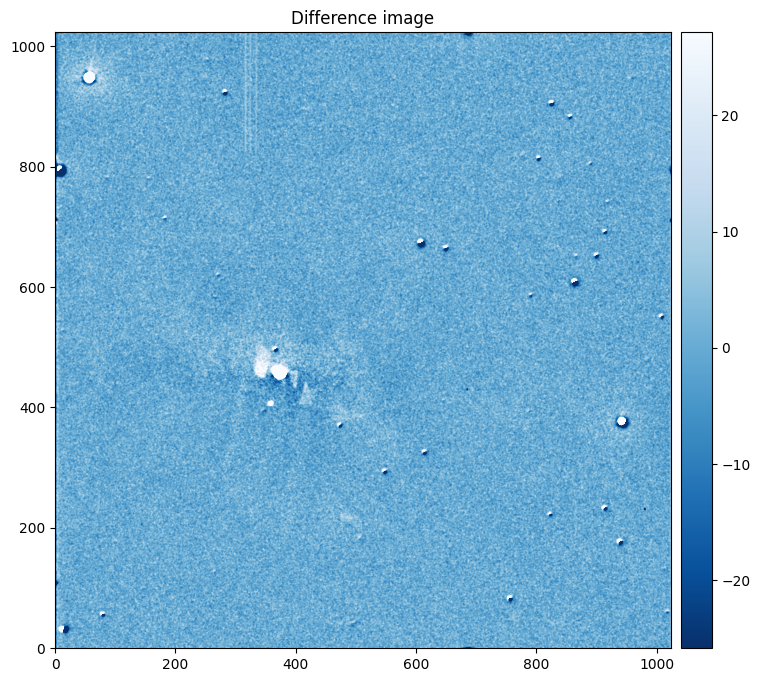

In [46]:
plots.imshow(D)
plt.title('Difference image')

Text(0.5, 1.0, 'Scorr - PSF-matched significance for the point sources')

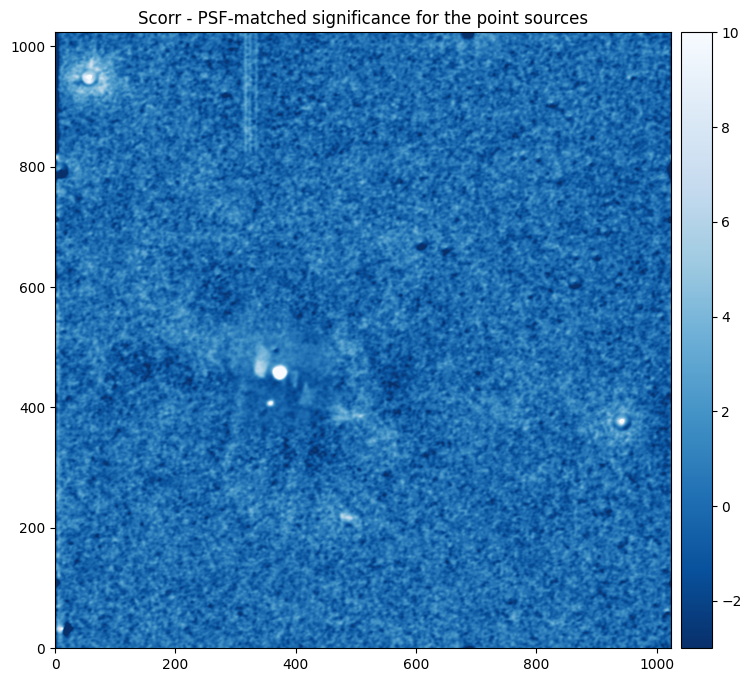

In [47]:
plots.imshow(S_corr, vmin=-3, vmax=10)
plt.title('Scorr - PSF-matched significance for the point sources')

Implementing transient detection on Scorr image is trivial and is left as an exercise for the reader

Text(0.5, 1.0, 'Scorr - ZOGY')

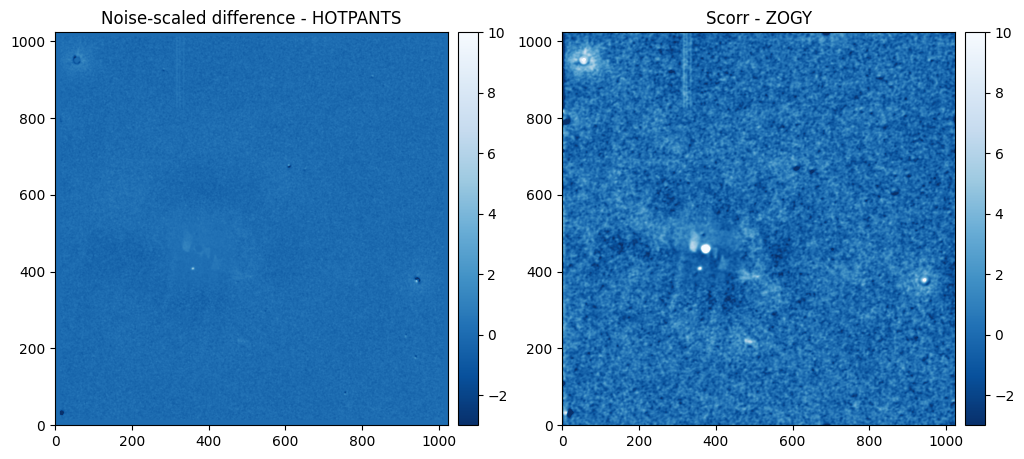

In [48]:
plt.subplot(121)
plots.imshow(sdiff, vmin=-3, vmax=10)
plt.title('Noise-scaled difference - HOTPANTS')

plt.subplot(122)
plots.imshow(S_corr, vmin=-3, vmax=10)
plt.title('Scorr - ZOGY')